# Compulsory Assignment 3: Semantic segmentation

Please fill out the the group name, number, members and optionally the name below.

**Group number**: 31\
**Group member 1**: Asim Rasheed\
**Group member 2**: Jony karmakar\
**Group member 3**: Haris Hameed Mian\
**Group name (optional)**: Group31


# Assignment Submission
To complete this assignment answer the relevant questions in this notebook and write the code required to implement the relevant models. This is the biggest assignemnt of the semester, and therefore you get two weeks to work on it. However, we reccomend that **you start early**. This assignment has three semi-big sections, each of which build upon the last. So if you delay the assignment until the day before submission, you will most likely fail. This assignment is completed by doing the following. 
* Submit notebook as an .ipynb file to canvas.
* Submit notebook as an .pdf file to canvas.
* Submit the python script you run on ORION to canvas.
* Submit the SLURM script you run on ORION to canvas.
* Submit at least one of your model predictions to the Kaggle leaderboard, and attain a score that is higher than the *BEAT ME* score. 

NOTE: Remember to go through the rules given in the lecture "Introduction to compulsory assignments", as there are many do's and dont's with regard to how you should present the work you are going to submit.



# Introduction 
This assignment will center around semantic segmentation of the dataset in the TGS salt identification challenge. Several of the Earths accumulations of oil and gas **also** have huge deposits of salt, which is easier to detect than the actual hydrocarbons. However, knowing where the salt deposits are precisely is still quite difficult, and segmentation of the seismic images is still something that requires expert interpretation of the images. This leads variable, and highly subjective renderings. To create more accurate, objective segmentations TGS (the worlds leading geoscience data company) have created this challenge to determine if a deep learning model is up to the task. 

## Dataset
In this assigmnet you will be given 3500 annotated images. The image, and mask dimensions are 128x128 pixels. With each image there follows an annotation mask where each pixel is classified as `1` (salt deposit) or `0` not salt deposit. The test-dataset contains 500 images, where no ground truth masks are given. To evualuate your model on the test dataset, submit your predictions to the Kaggle leaderboard.

## Assignment tasks

1. Implement a U-net model, and train it to segment the dataset.
2. Implement a U-net model that uses a pre-trained backbone model of your choice (VGGnet, ResNet, DarkNet, etc.), and train it to segment the dataset.
3. Train one of the models from part 1 or 2 on Orion, and compare the training times and attained performances.
4. Submit the best model prediction on Kaggle learderboard.


## Submissions to the Kaggle leaderboard

Link to the Kaggle leaderboard will be posted in the Canvas assignment.

```python
y_pred      = model.predict(X_test)                       # Make prediction
flat_y_pred = y_pred.flatten()                            # Flatten prediction
flat_y_pred[flat_y_pred >= USER_DETERMINED_THRESHOLD] = 1 # Binarize prediction (Optional, depends on output activation used)
flat_y_pred[flat_y_pred != 1]   = 0                       # Binarize prediction (Optional, depends on output activation used)
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_y_pred))              # The submission csv file must have a column called 'ID'
submissionDF['Prediction'] = flat_y_pred
submissionDF.to_csv('submission.csv', index=False)        # Remember to store the dataframe to csv without the nameless index column.
```


# Library imports

In [1]:
import time
from tqdm import tqdm # Cool progress bar
from time import time

import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow.keras as ks
import tensorflow as tf

SEED = 458 # Feel free to set another seed if you want to
RNG = np.random.default_rng(SEED) # Random number generator
tf.random.set_seed(SEED)

from utilities import *
from visualization import *

c:\NMBU\Miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data loading

Load the data from the HDF5 file `student_TGS_challenge.h5` that is available on Canvas, and Kaggle.
The data should be loaded in the same manner as in CA2. 

In [2]:
dataset_path = './student_TGS_challenge.h5'

with h5py.File(dataset_path,'r') as f:
    print('Datasets in file:', list(f.keys()))
    X_train = np.asarray(f['X_train'])
    y_train = np.asarray(f['y_train'])
    X_test  = np.asarray(f['X_test'])
    print('Nr. train images: %i'%(X_train.shape[0]))
    print('Nr. test images: %i'%(X_test.shape[0]))

Datasets in file: ['X_test', 'X_train', 'y_train']
Nr. train images: 3500
Nr. test images: 500


# Visualization

Plot a few samples images and masks. Feel free to visualize any other aspects of the dataset that you feel are relevant. 

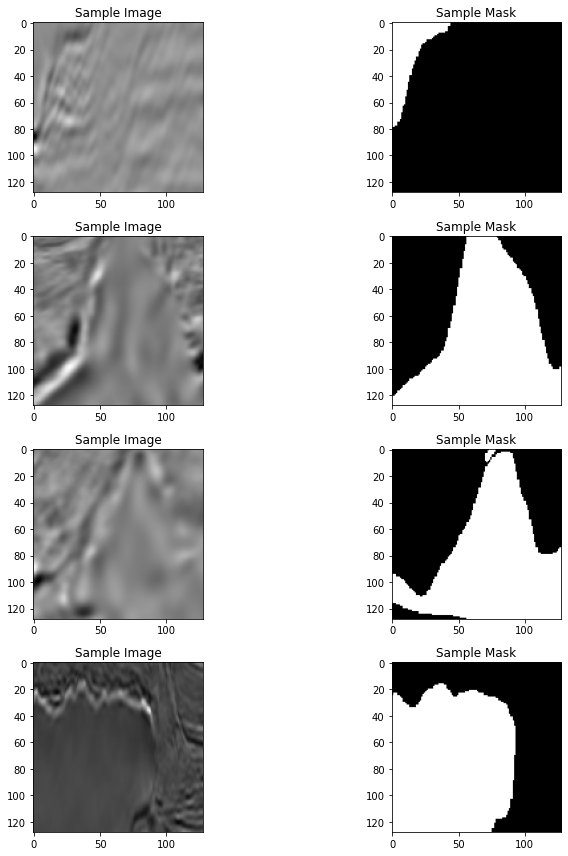

In [19]:

# Number of samples 
num_samples = 4

# subplot with the specified number of rows and columns
fig, axes = plt.subplots(num_samples, 2, figsize=(12, 12))

# plotting images and masks
for i in range(num_samples):
    # Plot the image
    axes[i, 0].imshow(X_train[i], cmap='gray')
    axes[i, 0].set_title('Sample Image')

    # Plot the mask
    axes[i, 1].imshow(y_train[i], cmap='gray')
    axes[i, 1].set_title('Sample Mask')

# Spacing between subplots
plt.tight_layout()
plt.show()


# Preprocessing

Preprocess the dataset in whatever ways you think are helpful. 

In [4]:
# Normalize the images
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

# Part 1: Implementing U-net

## Intersection over Union

The IoU score is a popular metric in both segmentation and object detection problems. 

If you want to use the `plot_training_history` function in the `visualization.py` library remember to compile the model with the TP, TN, FP, FN metrics such that you can estimate the *Intersection-over-Union*. **However, it is voluntary to estimate IoU**

See example below:

```python
from tensorflow.keras.metrics import FalseNegatives, FalsePositives, TrueNegatives, TruePositives
from utilities import F1_score, 
from visualization import plot_training_history, 
...
model.compile(optimizer='Something', 
                  loss='Something else', 
                  metrics=[FalseNegatives(),
                           FalsePositives(),
                           TrueNegatives(),
                           TruePositives(),
                           F1_score,
                           OtherMetricOfChoice])

training_history = model.fit(X_train, y_train, ...)
plot_training_history(training_history)
```

You have also been provided with a custom F1-score metric in the `utilities.py` library, which is specific for image segmentation. **This is mandatory to use when compiling the model**.


## Task 1.1 Model implementation

Implement the classical U-net structure that you have learned about in the lectures. Feel free to experiment with the number of layers, loss-function, batch-normalization, etc. **Remember to compile with the F1-score metric**. 


In [5]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x =  ks.layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x =  ks.layers.BatchNormalization()(x)
    x =  ks.layers.Activation('relu')(x)
    
    # second layer
    x =  ks.layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm:
        x =  ks.layers.BatchNormalization()(x)
    x =  ks.layers.Activation('relu')(x)
    
    return x

def get_unet(input_img, n_filters=16, dropout=0.1, batchnorm=True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = ks.layers.MaxPooling2D((2, 2))(c1)
    p1 = ks.layers.Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = ks.layers.MaxPooling2D((2, 2))(c2)
    p2 = ks.layers.Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = ks.layers.MaxPooling2D((2, 2))(c3)
    p3 = ks.layers.Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = ks.layers.MaxPooling2D((2, 2))(c4)
    p4 = ks.layers.Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters * 16, kernel_size=3, batchnorm=batchnorm)
    
    # Expansive Path
    u6 = ks.layers.Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = ks.layers.concatenate([u6, c4])
    u6 =ks.layers. Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size=3, batchnorm=batchnorm)
    
    u7 = ks.layers.Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = ks.layers.concatenate([u7, c3])
    u7 = ks.layers.Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size=3, batchnorm=batchnorm)
    
    u8 = ks.layers.Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = ks.layers.concatenate([u8, c2])
    u8 = ks.layers.Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size=3, batchnorm=batchnorm)
    
    u9 = ks.layers.Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = ks.layers.concatenate([u9, c1])
    u9 = ks.layers.Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = ks.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = ks.Model(inputs=[input_img], outputs=[outputs])
    return model

# Define the U-Net model
input_img = ks.layers.Input((128, 128, 3))
model = get_unet(input_img)

# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy',
                       F1_score,
                       tf.keras.metrics.FalseNegatives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.TruePositives()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 16)         0         ['batch_normalization[0][0

## Task 1.2 Train the model, and plot the training history
Feel free to use the `plot_training_history` function from the provided library `utilities.py`

In [6]:
training_history = model.fit(X_train_normalized, y_train, 
                             batch_size=32, 
                             epochs=30, 
                             validation_split=0.2,  # Use 10% of the data for validation
                             shuffle=True)


Epoch 1/30
88/88 [==============================] - 132s 1s/step - loss: 0.4071 - accuracy: 0.8334 - F1_score: 0.6112 - false_negatives: 5143123.0000 - false_positives: 2498698.0000 - true_negatives: 31945636.0000 - true_positives: 6287747.0000 - val_loss: 6.9366 - val_accuracy: 0.3181 - val_F1_score: 0.4319 - val_false_negatives: 17726.0000 - val_false_positives: 7802529.0000 - val_true_negatives: 638201.0000 - val_true_positives: 3010344.0000
Epoch 2/30
88/88 [==============================] - 128s 1s/step - loss: 0.3007 - accuracy: 0.8854 - F1_score: 0.7485 - false_negatives: 3458509.0000 - false_positives: 1799365.0000 - true_negatives: 32644960.0000 - true_positives: 7972361.0000 - val_loss: 2.1645 - val_accuracy: 0.6502 - val_F1_score: 0.5729 - val_false_negatives: 274986.0000 - val_false_positives: 3737211.0000 - val_true_negatives: 4703519.0000 - val_true_positives: 2753084.0000
Epoch 3/30
88/88 [==============================] - 126s 1s/step - loss: 0.2703 - accuracy: 0.8965 -

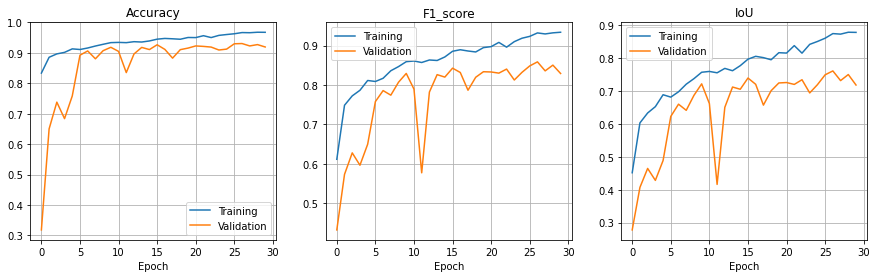

In [53]:
# keys_to_rename = ['false_negatives_1', 'false_positives_1', 'true_negatives_1', 'true_positives_1',
#                   'val_false_negatives_1', 'val_false_positives_1', 'val_true_negatives_1', 'val_true_positives_1']

# for key in keys_to_rename:
#     new_key = key.replace('_1', '')
#     training_history.history[new_key] = training_history.history.pop(key)

# Plot the training history
plot_training_history(training_history)

## Task 1.3 Visualize model predictions

Make a plot that illustrates the original image, the predicted mask, and the ground truth mask. 

110/110 [==============================] - 25s 227ms/step


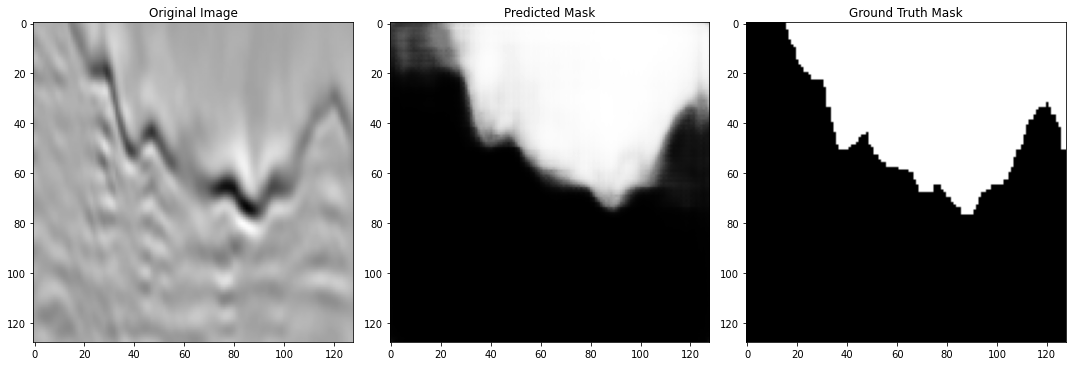

In [79]:
def visualize_predictions(X, y_true, y_pred, num_samples=1):
    """Visualize random samples from predictions."""
    indices = np.random.choice(X.shape[0], num_samples, replace=False)
    
    for idx in indices:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        
        ax1.imshow(X[idx], cmap='gray')
        ax1.set_title("Original Image")
        
        ax2.imshow(y_pred[idx].squeeze(), cmap='gray')
        ax2.set_title("Predicted Mask")
        
        ax3.imshow(y_true[idx].squeeze(), cmap='gray')
        ax3.set_title("Ground Truth Mask")

        plt.tight_layout()
        plt.show()

# Make predictions
predictions = model.predict(X_train_normalized)

# Call the function to visualize the samples
visualize_predictions(X_train_normalized, y_train, predictions)



In [9]:
USER_DETERMINED_THRESHOLD = 0.5
y_pred      = model.predict(X_test_normalized)            # Make prediction
flat_y_pred = y_pred.flatten()                            # Flatten prediction
flat_y_pred[flat_y_pred >= USER_DETERMINED_THRESHOLD] = 1 # Binarize prediction (Optional, depends on output activation used)
flat_y_pred[flat_y_pred != 1]   = 0                       # Binarize prediction (Optional, depends on output activation used)
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_y_pred))              # The submission csv file must have a column called 'ID'
submissionDF['Prediction'] = flat_y_pred
submissionDF.to_csv('submission16.csv', index=False)  

16/16 [==============================] - 4s 241ms/step


# Part 2: Implementing U-net with transfer learning

Implement a model with the U-net structure that you have learned about in the lectures, but now with a pre-trained backbone. There are many pre-trained back-bones to choose from. Pick freely from the selection here [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), or here [Keras model scores](https://keras.io/api/applications/) (nicer table in the second link). Feel free to experiment with the number of layers, loss-function, batch-normalization, etc. Many of the backbones available are quite big, so you might find it quite time-consuming to train them on your personal computers. It might be expedient to only train them for 1-5 epochs on your PCs, and do the full training on Orion in Part 3. 

## Task 2.1 Transfer learning model implementation

Implement a U-net model utilizing the pre-trained weights of a publically available network. **Remember to compile with the F1-score metric**.

In [ ]:
def unet_with_vgg16(input_shape):
    # Load the VGG16 model 
    base_model = ks.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Encoder 
    encoder = base_model.get_layer('block5_pool').output  # Extract features from the last pooling layer

    # Decoder 
    x = ks.layers.UpSampling2D((2, 2))(encoder)
    x = ks.layers.concatenate([x, base_model.get_layer('block5_conv3').output])
    x = ks.layers.Conv2D(512, (3, 3), padding='same')(x)
    x = ks.layers.BatchNormalization()(x)
    x = ks.layers.Activation('relu')(x)

    x = ks.layers.UpSampling2D((2, 2))(x)
    x = ks.layers.concatenate([x, base_model.get_layer('block4_conv3').output])
    x = ks.layers.Conv2D(512, (3, 3), padding='same')(x)
    x = ks.layers.BatchNormalization()(x)
    x = ks.layers.Activation('relu')(x)

    x = ks.layers.UpSampling2D((2, 2))(x)
    x = ks.layers.concatenate([x, base_model.get_layer('block3_conv3').output])
    x = ks.layers.Conv2D(256, (3, 3), padding='same')(x)
    x = ks.layers.BatchNormalization()(x)
    x = ks.layers.Activation('relu')(x)

    x = ks.layers.UpSampling2D((2, 2))(x)
    x = ks.layers.concatenate([x, base_model.get_layer('block2_conv2').output])
    x = ks.layers.Conv2D(128, (3, 3), padding='same')(x)
    x = ks.layers.BatchNormalization()(x)
    x = ks.layers.Activation('relu')(x)

    x = ks.layers.UpSampling2D((2, 2))(x)
    x = ks.layers.concatenate([x, base_model.get_layer('block1_conv2').output])
    x = ks.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = ks.layers.BatchNormalization()(x)
    x = ks.layers.Activation('relu')(x)

    # Final output layer
    outputs = ks.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    
    # Freeze the layers of VGG16 (optional)
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

# Define the U-Net model with VGG16 
model_transfer = unet_with_vgg16((128, 128, 3))  

model_transfer.compile(optimizer='adam', 
                       loss='binary_crossentropy', 
                       metrics=[F1_score,
                                tf.keras.metrics.FalseNegatives(),
                                tf.keras.metrics.FalsePositives(),
                                tf.keras.metrics.TrueNegatives(),
                                tf.keras.metrics.TruePositives()])

model_transfer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 128, 128, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 128, 128, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)           0         ['block1_conv2[0][0]']        
                                                                                            

## Task 2.2 Train the transfer learning model and plot the training history

Feel free to use the `plot_training_history` function from the provided library `utilities.py`

In [21]:
# Train the model
start_time = time()
training_history = model_transfer.fit(X_train_normalized, y_train, 
                             batch_size=32, 
                             epochs=1, 
                             validation_split=0.2,  # Use 20% of the data for validation
                             shuffle=True)
end_time = time()

Epoch 1/5
88/88 [==============================] - 1946s 22s/step - loss: 0.1831 - F1_score: 0.8486 - false_negatives_1: 2090635.0000 - false_positives_1: 1159282.0000 - true_negatives_1: 33285048.0000 - true_positives_1: 9340235.0000 - val_loss: 0.2223 - val_F1_score: 0.8117 - val_false_negatives_1: 668751.0000 - val_false_positives_1: 366310.0000 - val_true_negatives_1: 8074420.0000 - val_true_positives_1: 2359319.0000
Epoch 2/5
88/88 [==============================] - 1773s 20s/step - loss: 0.1713 - F1_score: 0.8543 - false_negatives_1: 2054361.0000 - false_positives_1: 1048028.0000 - true_negatives_1: 33396308.0000 - true_positives_1: 9376509.0000 - val_loss: 0.2180 - val_F1_score: 0.8036 - val_false_negatives_1: 776808.0000 - val_false_positives_1: 257343.0000 - val_true_negatives_1: 8183387.0000 - val_true_positives_1: 2251262.0000
Epoch 3/5
88/88 [==============================] - 1701s 19s/step - loss: 0.1601 - F1_score: 0.8664 - false_negatives_1: 1846222.0000 - false_positive

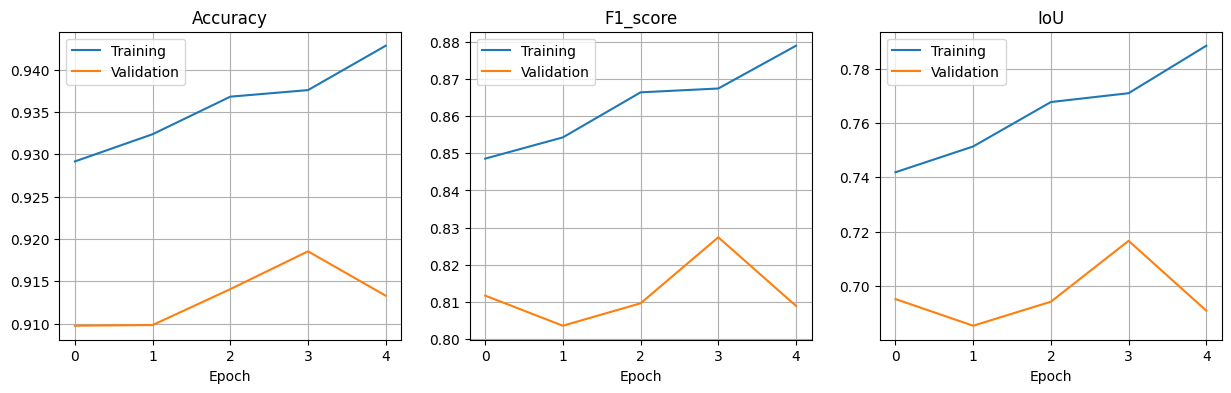

In [22]:
keys_to_rename = ['false_negatives_1', 'false_positives_1', 'true_negatives_1', 'true_positives_1',
                  'val_false_negatives_1', 'val_false_positives_1', 'val_true_negatives_1', 'val_true_positives_1']

for key in keys_to_rename:
    new_key = key.replace('_1', '')
    training_history.history[new_key] = training_history.history.pop(key)

# Plot the training history
plot_training_history(training_history)
training_time = (end_time - start_time)/3600 # in hours
print('It took %.2f hours to train the model'%(training_time))

16/16 [==============================] - 110s 7s/step


# Part 3: Training your model Orion

Use the lecture slides from the Orion-lecture to get started.
1. Put one of your model implementations into a python script (`.py`)
2. Transfer that script to Orion.
3. Change the relevant path variables in your python script (path-to-data for example), and make sure that you record the time it takes to train the model in the script. This can be done using the `time` library for example.
4. Set up a SLURM-script to train your model, please use the example from the Orion lecture as a base.
5. Submit your SLURM job, and let the magic happen. 

If you wish to use a model trained on Orion to make a Kaggle submission, remeber to save the model, such that you can transfer it to your local computer to make a prediction on `X_test`, or test the model on Orion directly if you want to. 

## Tips

If you compiled, trained and stored a model on Orion with a custom performance metric (such as F1-score), remember to specify that metric when loading the model on your computer again.

Loading a saved model:
```python
trained_model = tf.keras.models.load_model('some/path/to/my_trained_model.keras', custom_objects={'F1_score': F1_score})
```

Loading a checkpoint:
```python
trained_model = tf.keras.saving.load_model('some/path/to/my_trained_model_checkpoint', custom_objects={'F1_score': F1_score})
```

# Discussion

**Question 1: Which model architectures did you explore, and what type of hyperparameter optimization did you try?**

**Answer 1:** We explored the U-Net architecture for semantic segmentation. Additionally, we applied transfer learning by using a pre-trained backbone. We experimented with various available models, such as VGG16, ResNet50, and ResNet50V2. To optimize hyperparameters, we made adjustments to the batch size, number of epochs, the quantity of neurons in each layer, and the depth of the network by varying the number of layers.

**Question 2: Which of the model(s) did you choose to train on Orion, and how long did it take to train it on Orion?**

**Answer 2:** We opted for the U-Net model on Orion and also experimented with transfer learning using the VGG16 model. The training process on Orion proved to be significantly faster compared to our own laptop. For the same training model configuration on our laptop, it took 10,800 seconds, while on Orion, it only required 473 seconds. Training on Orion was approximately 20 times faster than on a personal computer.

**Question 3: What where the biggest challenges with this assignment?**

**Answer 3:** 

o The biggest challenges with this assignment were training the model on Orion. It took some time to get used to it. However, once we understood it, it was no longer a challenge.

o Another challenge was hyperparameter optimization. We had to do this manually, which is why we found it challenging. In the future, we would like to explore methods and techniques for performing   hyperparameter optimization using scripting, so that parameters can be adjusted automatically.

o Additionally, we encountered challenges in improving the accuracy of the model. Despite making significant parameter changes, our efforts didn't lead to a substantial accuracy improvement. For example, in our Kaggle submission, we achieved an initial accuracy of 0.833, which we later improved to 0.888, resulting in a 6.6% increase. Perhaps by employing optimization techniques or other methods, we can further enhance the model's accuracy.

# Kaggle submission

Evaluate your best model on the test dataset and submit your prediction to the Kaggle leaderboard.
Link to the Kaggle leaderboard will be posted in the Canvas assignment.

In [ ]:
USER_DETERMINED_THRESHOLD = 0.5
y_pred      = model_transfer.predict(X_test_normalized)            # Make prediction
flat_y_pred = y_pred.flatten()                            # Flatten prediction
flat_y_pred[flat_y_pred >= USER_DETERMINED_THRESHOLD] = 1 # Binarize prediction (Optional, depends on output activation used)
flat_y_pred[flat_y_pred != 1]   = 0                       # Binarize prediction (Optional, depends on output activation used)
submissionDF = pd.DataFrame()
submissionDF['ID'] = range(len(flat_y_pred))              # The submission csv file must have a column called 'ID'
submissionDF['Prediction'] = flat_y_pred
submissionDF.to_csv('submission1.csv', index=False)  


16/16 [==============================] - 110s 7s/step
